# Hw 09 - Lie Detection(Fake Reviews) and Sentiment Analysis

In [2]:
# importing required libraries

import pandas as pd
import seaborn as sns
import numpy as np

import nltk # For doing some preprocessing on our string data
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords # We will do some cleanup of the text
from tqdm import tqdm # This is an iterator that makes nice prorgess bars

import re

from tensorflow import keras # As usual, we will use keras as a front end to TF
from nltk.tokenize import sent_tokenize, word_tokenize # Cleanup will start with tokenization

# Utility functions from TF
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Some Keras utility functions and sequential layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout

# For building our own Word2vec model
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# reading the data from csv file
review_list = []
lie_list = []
sentiment_list = []
with open('/content/drive/Othercomputers/My Laptop/syr_ads_ist707/week09text_mining/hw09/deception_data_converted_final.csv') as file_handler:
    lines = file_handler.readlines()
    # skipping header row
    for line in lines[1:]:
      line = line.strip() # removing trailing whitespaces
      columns = line.split(',')
      lie_list.append(columns[0]) # collecting lie
      sentiment_list.append(columns[1]) # collecting sentiment
      review_list.append(','.join(columns[2:])) # collecting reviews

In [5]:
review_dict = {'lie':lie_list,'sentiment':sentiment_list,'review':review_list}
df = pd.DataFrame(review_dict)
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in data set')

There are 92 rows and 3 columns in data set


In [6]:
df.head()

,lie,sentiment,review
0,f,n,"'Mike\'s Pizza High Point, NY Service was very..."
1,f,n,'i really like this buffet restaurant in Marsh...
2,f,n,"'After I went shopping with some of my friend,..."
3,f,n,'Olive Oil Garden was very disappointing. I ex...
4,f,n,'The Seven Heaven restaurant was never known f...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lie        92 non-null     object
 1   sentiment  92 non-null     object
 2   review     92 non-null     object
dtypes: object(3)
memory usage: 2.3+ KB


In [8]:
# replacing any empty string in review to null
df = df.apply(lambda x: x.str.strip()).replace('', np.nan)

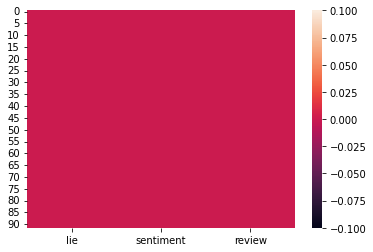

In [9]:
sns.heatmap(df.isnull()) # no null values found

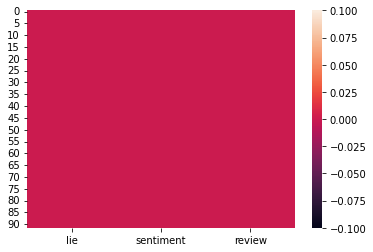

In [10]:
sns.heatmap(df.isna()) # no NA found

In [11]:
# checking for duplicate rows in the data
df[df.duplicated()==True]

,lie,sentiment,review
83,t,p,?


In [12]:
df[df['review']=='?']

,lie,sentiment,review
82,t,p,?
83,t,p,?


In [13]:
df.drop(df[df['review']=='?'].index, inplace=True) # removing rows having '?' in review

In [14]:
df.shape

(90, 3)

In [15]:
df.describe().T

,count,unique,top,freq
lie,90,2,f,46
sentiment,90,2,n,46
review,90,90,"'Mike\'s Pizza High Point, NY Service was very...",1


In [16]:
df['lie'].value_counts()

f    46
t    44
Name: lie, dtype: int64

In [17]:
df['sentiment'].value_counts()

n    46
p    44
Name: sentiment, dtype: int64

In [18]:
df.reset_index(inplace=True)

# Data Pre Processing

In [19]:
# converting categorical variables 'lie' and 'sentiment' to numeric values
df['lie'].replace({'f':1,'t':0}, inplace=True) # 1 indicates fake review, 0 indicates not a fake review
df['sentiment'].replace({'n':0,'p':1}, inplace=True) # 0 indicates negative polarity, 1 indicates positive polarity

# Sentiment Analysis

In [35]:
# using twitter dataset from kaggle https://www.kaggle.com/crowdflower/twitter-airline-sentiment for training the model


tweetsdf = pd.read_csv('/content/drive/Othercomputers/My Laptop/syr_ads_ist707/week09text_mining/hw09/Tweets.zip')
tweetsdf.shape

(14640, 15)

In [36]:
tweetsdf.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [37]:
tweetsdf['text'] = tweetsdf['text'].apply(str.lower) # lowercase transformation

In [38]:
tweetsdf['text']

0                      @virginamerica what @dhepburn said.
1        @virginamerica plus you've added commercials t...
2        @virginamerica i didn't today... must mean i n...
3        @virginamerica it's really aggressive to blast...
4        @virginamerica and it's a really big bad thing...
                               ...                        
14635    @americanair thank you we got on a different f...
14636    @americanair leaving over 20 minutes late flig...
14637    @americanair please bring american airlines to...
14638    @americanair you have my money, you change my ...
14639    @americanair we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [39]:
# removing twitter name tags
tweetsdf['clean_text'] = tweetsdf['text'].str.replace('(@\w+.*?)',"")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [40]:
# removing twitter hash tags
tweetsdf['clean_text'] = tweetsdf['clean_text'].str.replace('(#\w+.*?)',"")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [41]:
tweetsdf['clean_text']

0                                              what  said.
1         plus you've added commercials to the experien...
2         i didn't today... must mean i need to take an...
3         it's really aggressive to blast obnoxious "en...
4                 and it's a really big bad thing about it
                               ...                        
14635     thank you we got on a different flight to chi...
14636     leaving over 20 minutes late flight. no warni...
14637                   please bring american airlines to 
14638     you have my money, you change my flight, and ...
14639     we have 8 ppl so we need 2 know how many seat...
Name: clean_text, Length: 14640, dtype: object

In [42]:
# Unique values of sentiment
tweetsdf['airline_sentiment'].unique()


array(['neutral', 'positive', 'negative'], dtype=object)

In [43]:
tweetsdf.drop(tweetsdf[tweetsdf['airline_sentiment'] = 'neutral'].index, inplace = True)

SyntaxError: ignored

Naive Bayes

SVC

# Lie Detection (Fake Reviews)

Naive Bayes

SVC